# Sentiment Analysis of Twitter US Airline Data, SVM

In [1]:
# Before the start, supress deprecation warnings resulting from nltk on Kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [31]:
import pandas as pd
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
import collections
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

In [7]:
tweets = pd.read_csv("C:/Users/mikay/Documents/AUA/Capstone/Dataset/Tweets.csv")
list(tweets.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [8]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
#Take a look what sentiments have been found
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [11]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [13]:
normalizer("Some random text about an airline I like.")

['text', 'airline', 'like']

In [14]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.text.apply(normalizer)
tweets[['text','normalized_tweet']].head()

,text,normalized_tweet
0,@VirginAmerica What @dhepburn said.,"[dhepburn, said]"
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[added, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [16]:
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,[dhepburn said]
1,"[added commercial, commercial experience, experience tacky, added commercial experience, commercial experience tacky]"
2,"[today must, must mean, mean need, need take, take another, another trip, today must mean, must mean need, mean need take, need take another, take another trip]"
3,"[really aggressive, aggressive blast, blast obnoxious, obnoxious entertainment, entertainment guest, guest face, face amp, amp little, little recourse, really aggressive blast, aggressive blast obnoxious, blast obnoxious entertainment, obnoxious entertainment guest, entertainment guest face, guest face amp, face amp little, amp little recourse]"
4,"[really big, big bad, bad thing, really big bad, big bad thing]"


In [18]:
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [19]:
tweets[(tweets.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(20)

[('http co', 449),
 ('customer service', 438),
 ('cancelled flightled', 425),
 ('late flight', 215),
 ('cancelled flighted', 196),
 ('flight cancelled', 185),
 ('late flightr', 144),
 ('cancelled flight', 131),
 ('hold hour', 128),
 ('flightled flight', 123),
 ('flight cancelled flightled', 117),
 ('flight delayed', 115),
 ('cancelled flightled flight', 107),
 ('call back', 106),
 ('booking problem', 98),
 ('gate agent', 83),
 ('flight flight', 74),
 ('hour late', 69),
 ('delayed flight', 69),
 ('flight attendant', 60)]

In [20]:
tweets[(tweets.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(20)

[('http co', 233),
 ('customer service', 91),
 ('flight attendant', 25),
 ('quick response', 19),
 ('great flight', 17),
 ('best airline', 16),
 ('great job', 16),
 ('great service', 16),
 ('gate agent', 16),
 ('booking problem', 15),
 ('thanks help', 15),
 ('thank much', 15),
 ('good work', 14),
 ('fleet fleek', 14),
 ('fleek http', 14),
 ('fleet fleek http', 14),
 ('fleek http co', 14),
 ('guy rock', 13),
 ('looking forward', 13),
 ('great customer', 12)]

In [22]:
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [23]:
vectorized_data = count_vectorizer.fit_transform(tweets.text)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [24]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.airline_sentiment.apply(sentiment2target)

In [26]:
#Train Test split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [28]:
#Fitting the classifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

In [29]:
#Evaluation of the results
clf.score(data_test, targets_test)

0.7851775956284153

In [30]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.20996927, 0.05737602, 0.73265471],
       [0.14266533, 0.06955011, 0.78778456],
       [0.94312611, 0.0384254 , 0.01844849],
       [0.89002514, 0.07088884, 0.03908602],
       [0.97373849, 0.01637291, 0.0098886 ],
       [0.46447981, 0.50297637, 0.03254381],
       [0.2635322 , 0.52157125, 0.21489655]])

In [33]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [34]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[0:10]))

['.@JetBlue this is enough for me to stop flying JetBlue.',
 "@united I have flights that don't appear to have been applied to my MileagePlus account. Can you help?",
 '@JetBlue - Definitely no note from whoever stole from me.',
 '@SouthwestAir I am but it says yall are sold out. Me &amp; My coworkers would need to get out first available',
 '@united How can I verify if wheelchair assistance has been requested for my next flight?',
 '@united well played, ^LO.',
 '@AmericanAir overall lack of attention or foresight when managing flights.',
 '@JetBlue two rows',
 '@SouthwestAir @karajusto SWA is willing to follow up. FINALLY.',
 "@USAirways that's it?!?!?"]

In [35]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([0.31937554, 0.34031092, 0.34031354]),
 array([0.49736343, 0.49728896, 0.0053476 ]),
 array([0.47034525, 0.05920458, 0.47045017]),
 array([0.49929851, 0.4987922 , 0.00190929]),
 array([0.48850913, 0.48927442, 0.02221644]),
 array([0.27513059, 0.36283003, 0.36203938]),
 array([0.48684615, 0.48565321, 0.02750064]),
 array([0.35893659, 0.36015424, 0.28090917]),
 array([0.37814814, 0.24236476, 0.3794871 ]),
 array([0.42046205, 0.42195389, 0.15758406])]

In [36]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].text, margin[-10:]))

['@united here we go again. 2 of 3 segments SFO--New York RT were delayed OVER 2 hrs each! Why do you suck so BAD!?!Maybe another line of bus?',
 '@USAirways Been stuck for 40+ minutes due to lavatory issues. No beverages. No snacks. No customer service. Flt 645 to PHO... #fail #refund',
 '@united is the worst airline. Lost my luggage delayed my flights and has been very unaccomidating',
 '@AmericanAir Worst airline ever. We have been stranded for 24 hours because of your 7 hour delay with flight 104 last night.',
 "@USAirways seriously???  did you not see that I've spent 2 days - for multiple hours on hold just to have to hang up after the hours?",
 '@AmericanAir AA 1657 was also over an hour Late Flight to depart Ohare and now we have no luggage. Not happy standing in a long line at baggage svc',
 '@USAirways waited for 3 hours NO LUGGAGE line too long left airport when flight Cancelled Flighted WHERE does luggage GO? On hold for 1 hour so far',
 '@united you are the worst airline in

In [37]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([0.99727749, 0.00158063, 0.00114188]),
 array([9.97860414e-01, 1.22091602e-03, 9.18669732e-04]),
 array([9.98005726e-01, 1.33985769e-03, 6.54416264e-04]),
 array([9.98753860e-01, 1.01981378e-03, 2.26326359e-04]),
 array([9.98856050e-01, 1.06430192e-03, 7.96484684e-05]),
 array([9.98690183e-01, 6.53801796e-04, 6.56015158e-04]),
 array([9.99060393e-01, 8.35796501e-04, 1.03810590e-04]),
 array([9.99116319e-01, 1.82765983e-04, 7.00915512e-04]),
 array([9.99031729e-01, 5.37796052e-04, 4.30474475e-04]),
 array([9.99456812e-01, 3.18129499e-04, 2.25058600e-04])]

## All Data

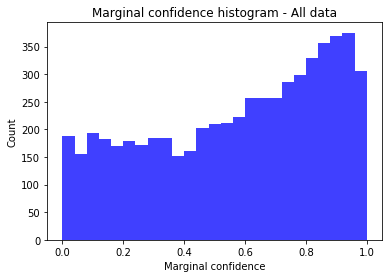

In [38]:
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

## Positive Data

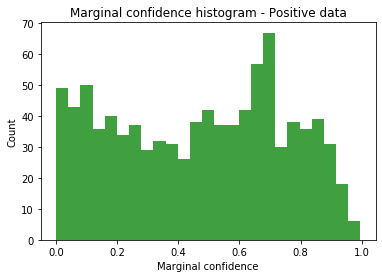

In [39]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

## Neutral Data

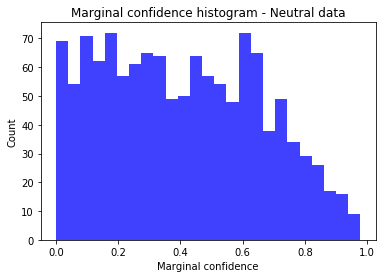

In [40]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

## Negative Data

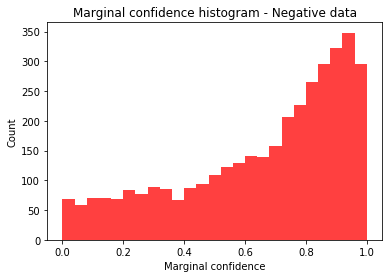

In [41]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()